# Tutorial 7: ARGA & ARVGA  

Paper:
* [Adversarially Regularized Graph Autoencoder for Graph Embedding](https://www.ijcai.org/Proceedings/2018/0362.pdf)  

Code:
 * [ARGA & ARVGA](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/autoencoder.html)
 * [Example on clustering](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/argva_node_clustering.py)

In [1]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.8.0+cpu


## Imports

In [2]:
import os.path as osp
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import (v_measure_score, homogeneity_score, completeness_score)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models.autoencoder import ARGVA
from torch_geometric.utils import train_test_split_edges

/home/lukas/git_repos/PytorchGeometricTutorial/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
use_cuda = False

## Define the dataset

Download the dataset

In [4]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset.get(0)

Processing...
Done!


Get the number of nodes

In [5]:
num_nodes = data.x.shape[0]

Create the train/val/test data

In [6]:
data.train_mask = data.val_mask = data.test_mask = None
data = train_test_split_edges(data)
data

/tmp/ipykernel_38627/811160384.py:2: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  data = train_test_split_edges(data)


Data(x=[2708, 1433], y=[2708], val_pos_edge_index=[2, 263], test_pos_edge_index=[2, 527], train_pos_edge_index=[2, 8976], train_neg_adj_mask=[2708, 2708], val_neg_edge_index=[2, 263], test_neg_edge_index=[2, 527])

## Define the model

Define the encoder classes (the same as in `Tutorial 6`)

In [7]:
class VEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

Define the discriminator class

In [8]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Discriminator, self).__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

Define the training algorithm

In [9]:
def train():
    model.train()
    encoder_optimizer.zero_grad()
    
    z = model.encode(data.x, data.train_pos_edge_index)

    for i in range(5):
        idx = range(num_nodes)  
        discriminator.train()
        discriminator_optimizer.zero_grad()
        discriminator_loss = model.discriminator_loss(z[idx]) # Comment
        discriminator_loss.backward(retain_graph=True)
        discriminator_optimizer.step()
 
    loss = 0
    loss = loss + model.reg_loss(z)  # Comment
    
    loss = loss + model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()

    encoder_optimizer.step()
    
    return loss

Define a training test method

In [10]:
@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)

    # Cluster embedded values using k-means.
    kmeans_input = z.cpu().numpy()
    kmeans = KMeans(n_clusters=7, random_state=0).fit(kmeans_input)
    pred = kmeans.predict(kmeans_input)

    labels = data.y.cpu().numpy()
    completeness = completeness_score(labels, pred)
    hm = homogeneity_score(labels, pred)
    nmi = v_measure_score(labels, pred)

    auc, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

    return auc, ap, completeness, hm, nmi

## Initialize the model

Initialize an encoder and a discriminator

In [11]:
latent_size = 32
encoder = VEncoder(data.num_features, out_channels=latent_size)

discriminator = Discriminator(in_channels=latent_size, hidden_channels=64, 
                              out_channels=1) # Comment

Initialize the model and move everything to the GPU

In [12]:
model = ARGVA(encoder, discriminator)

device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
model, data = model.to(device), data.to(device)

Define the optimizers

In [13]:
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.005)

### Train the model

In [14]:
for epoch in range(1, 201):
    loss = train()
    auc, ap, completeness, hm, nmi = test()
    print((f'Epoch: {epoch:03d}, Loss: {loss:.3f}, AUC: {auc:.3f}, '
           f'AP: {ap:.3f}, Completeness: {completeness:.3f}, '
           f'Homogeneity: {hm:.3f}, NMI: {nmi:.3f}'))

Epoch: 001, Loss: 5.393, AUC: 0.707, AP: 0.725, Completeness: 0.101, Homogeneity: 0.099, NMI: 0.100
Epoch: 002, Loss: 4.760, AUC: 0.676, AP: 0.705, Completeness: 0.082, Homogeneity: 0.080, NMI: 0.081
Epoch: 003, Loss: 4.099, AUC: 0.667, AP: 0.699, Completeness: 0.054, Homogeneity: 0.052, NMI: 0.053
Epoch: 004, Loss: 3.580, AUC: 0.671, AP: 0.703, Completeness: 0.053, Homogeneity: 0.050, NMI: 0.052
Epoch: 005, Loss: 3.185, AUC: 0.687, AP: 0.716, Completeness: 0.078, Homogeneity: 0.077, NMI: 0.078
Epoch: 006, Loss: 2.778, AUC: 0.713, AP: 0.739, Completeness: 0.152, Homogeneity: 0.148, NMI: 0.150
Epoch: 007, Loss: 2.475, AUC: 0.729, AP: 0.756, Completeness: 0.201, Homogeneity: 0.199, NMI: 0.200
Epoch: 008, Loss: 2.236, AUC: 0.710, AP: 0.738, Completeness: 0.192, Homogeneity: 0.191, NMI: 0.191
Epoch: 009, Loss: 2.133, AUC: 0.695, AP: 0.723, Completeness: 0.152, Homogeneity: 0.148, NMI: 0.150
Epoch: 010, Loss: 2.095, AUC: 0.688, AP: 0.716, Completeness: 0.182, Homogeneity: 0.179, NMI: 0.180


In [15]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    fig = plt.figure(1, figsize=(8, 8))
    fig.clf()
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

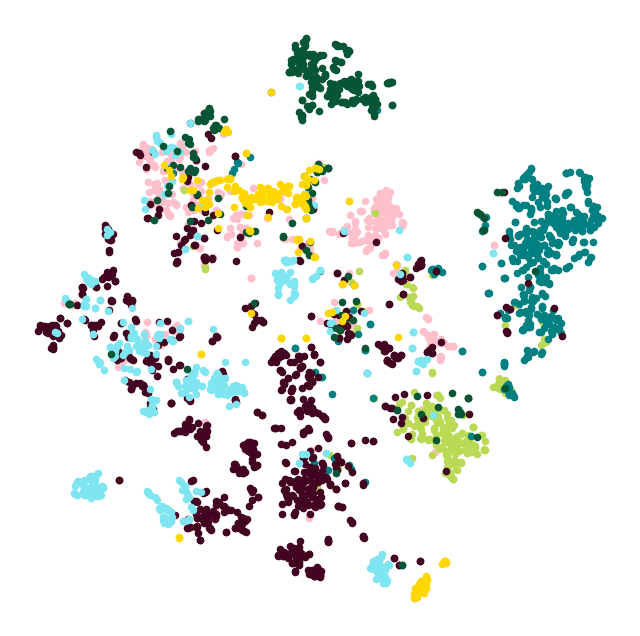

In [16]:
#%%
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)